<a href="https://colab.research.google.com/github/wafafatima66/Predicting-tags-using-multiclass-classification/blob/main/Multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("aclStack_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

6053168/6053168 [==============================] - 0s 0us/step


In [3]:
train_dir = os.path.join(os.path.dirname(dataset), 'train')
os.listdir(train_dir)

['python', 'javascript', 'java', 'csharp']

In [4]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
  print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [6]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [7]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [8]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [9]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [29]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [30]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [31]:
train_text

<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [32]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [33]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [34]:
embedding_dim = 16
# model = tf.keras.Sequential([
#   layers.Embedding(max_features, embedding_dim),
#   layers.Dropout(0.2),
#   layers.GlobalAveragePooling1D(),
#   layers.Dropout(0.2),
#   layers.Dense(4)])

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')  # Adjust the number of units to match the number of classes
])

In [35]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])


In [36]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160068 (625.27 KB)
Trainable params: 160068 (625.27 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [37]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 3s 12ms/step - loss: 1.3783 - accuracy: 0.3347 - val_loss: 1.3677 - val_accuracy: 0.4050
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 1.3505 - accuracy: 0.4684 - val_loss: 1.3303 - val_accuracy: 0.5281
Epoch 3/10
200/200 [==============================] - 4s 18ms/step - loss: 1.3020 - accuracy: 0.5327 - val_loss: 1.2740 - val_accuracy: 0.5644
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 1.2357 - accuracy: 0.5798 - val_loss: 1.2039 - val_accuracy: 0.6237
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 1.1593 - accuracy: 0.6373 - val_loss: 1.1277 - val_accuracy: 0.6662
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 1.0826 - accuracy: 0.6811 - val_loss: 1.0548 - val_accuracy: 0.7006
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 1.0072 - accuracy: 0.7113 - val_loss: 0.9883 - val_accuracy: 0.7194

In [38]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.8654 - accuracy: 0.7411
Loss:  0.8654435873031616
Accuracy:  0.7411249876022339


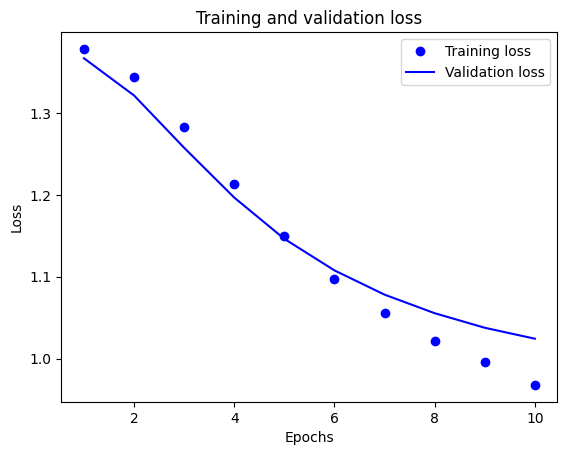

In [27]:
history_dict= history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


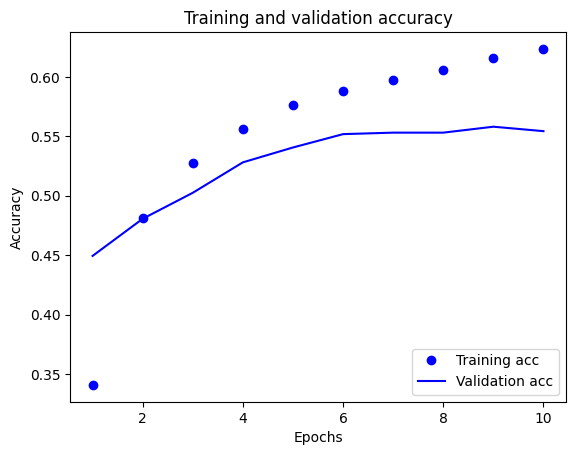

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
